# SnapATAC Analysis

Using data processed by Laksshman.

In [ ]:
library(SnapATAC)
library(GenomicRanges)
library(ggplot2) 

# https://github.com/r3fang/SnapATAC/tree/master/examples/10X_snATAC
# https://github.com/r3fang/SnapATAC/tree/master/examples/10X_brain_5k

In [2]:
SAMPLES = c(
#     "scATAC_W61_COLM_B_8817_X006_S08_B1_T1",
                "scATAC_W62_COLM_B_8850_X004_S08_B1_T1_S3")
#                 "scATAC_W64_MODC_B_10910_X016_S02_B1_T1_S15",
#                 "scATAC_W72_COLL_B_10922_X015_S06_B1_T1_S13",
#                 "scATAC_W73_COLL_B_10923_X005_S08_B1_T1_S16",
#                 "scATAC_W76_MODC_B_10931_X016_S03_B1_T1",
#                 "scATAC_W80_MODC_B_10947_X017_S01_B1_T1_S22")

FILE_PREFIX = "/srv/scratch/surag/colorectal"
BARCODES_PREFIX = "./barcodeLists/20200209_5kb_logcov_gt3_promratio_bw_0.2_0.8"

file.list = c()
barcode.file.list = c()

for (d in SAMPLES) {
    file.list = c(file.list, sprintf("%s/%s.snap", FILE_PREFIX, d))
    barcode.file.list = c(barcode.file.list, sprintf("%s/%s.barcodes.txt", BARCODES_PREFIX, d))
}

file.list
barcode.file.list

[1] "/srv/scratch/surag/colorectal/scATAC_W62_COLM_B_8850_X004_S08_B1_T1_S3.snap"

[1] "./barcodeLists/20200209_5kb_logcov_gt3_promratio_bw_0.2_0.8/scATAC_W62_COLM_B_8850_X004_S08_B1_T1_S3.barcodes.txt"

In [3]:
x.sp.ls = lapply(seq(file.list), function(i) {
    x.sp = createSnap(file = file.list[i],                      
                     sample = SAMPLES[i])
    x.sp
})

Epoch: reading the barcode session ...



In [4]:
# Filter cells using previously selected barcodes (see BarcodeSelection.ipynb)

barcode.list = lapply(barcode.file.list, function(file){
  read.table(file)[,1];
})
x.sp.list = lapply(seq(x.sp.ls), function(i){
  x.sp = x.sp.ls[[i]];
  x.sp  = x.sp[x.sp@barcode %in% barcode.list[[i]],];
})
names(x.sp.list) = SAMPLES;

In [5]:
x.sp.list

$scATAC_W62_COLM_B_8850_X004_S08_B1_T1_S3
number of barcodes: 3197
number of bins: 0
number of genes: 0
number of peaks: 0
number of motifs: 0


In [6]:
x.sp.list = lapply(seq(x.sp.list), function(i) {
    x.sp = addBmatToSnap(x.sp.list[[i]], bin.size=5000, num.cores=5)
    x.sp
})

Epoch: reading cell-bin count matrix session ...



In [7]:
bin.shared = Reduce(intersect, lapply(x.sp.list, function(x.sp) x.sp@feature$name));

In [8]:
# merge timepoints

x.sp.list <- lapply(x.sp.list, function(x.sp){
    idy = match(bin.shared, x.sp@feature$name);
    x.sp[,idy, mat="bmat"];
  })
x.sp = Reduce(snapRbind, x.sp.list);

In [9]:
x.sp

number of barcodes: 3197
number of bins: 620094
number of genes: 0
number of peaks: 0
number of motifs: 0

In [10]:
rm(x.sp.list); # free memory
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,4682352,250.1,8263238,441.4,5748948,307.1
Vcells,159588732,1217.6,490398664,3741.5,782329827,5968.8


In [11]:
x.sp = makeBinary(x.sp, mat="bmat");

In [12]:
tempCov = Matrix::rowSums(x.sp@bmat)

In [13]:
# remove UMIs with few bins
x.sp = x.sp[tempCov>1000, , mat="bmat"]
x.sp

number of barcodes: 3165
number of bins: 620094
number of genes: 0
number of peaks: 0
number of motifs: 0

In [16]:
# sampling few cells for speed (simplified analysis)
# sample_idx = sort(sample(seq(1,dim(x.sp@bmat)[1]), 10000))
# x.sp = x.sp[sample_idx,]
# x.sp

In [17]:
# OR keeping the same number of cells from each day
# fewest_per_day = min(table(x.sp@sample))
# print(fewest_per_day)

# idxs = c()
# for (d in SAMPLES) {
#     idxs = c(idxs, sample(which(x.sp@sample==d), fewest_per_day))
# }
# idxs = sort(idxs)

# table(x.sp@sample[idxs])

# x.sp = x.sp[idxs, ]

## Filtering bins

In [14]:
black_list = read.table("data/hg38.blacklist.bed.gz");
black_list.gr = GRanges(
    black_list[,1], 
    IRanges(black_list[,2], black_list[,3])
  );

In [15]:
idy = queryHits(findOverlaps(x.sp@feature, black_list.gr));

In [16]:
length(idy)

[1] 42

In [17]:
if(length(idy) > 0){x.sp = x.sp[,-idy, mat="bmat"]};

In [18]:
chr.exclude = seqlevels(x.sp@feature)[grep("random|chrM|chrUn", seqlevels(x.sp@feature))];
idy = grep(paste(chr.exclude, collapse="|"), x.sp@feature);
if(length(idy) > 0){x.sp = x.sp[,-idy, mat="bmat"]};

number of barcodes: 3165
number of bins: 542563
number of genes: 0
number of peaks: 0
number of motifs: 0

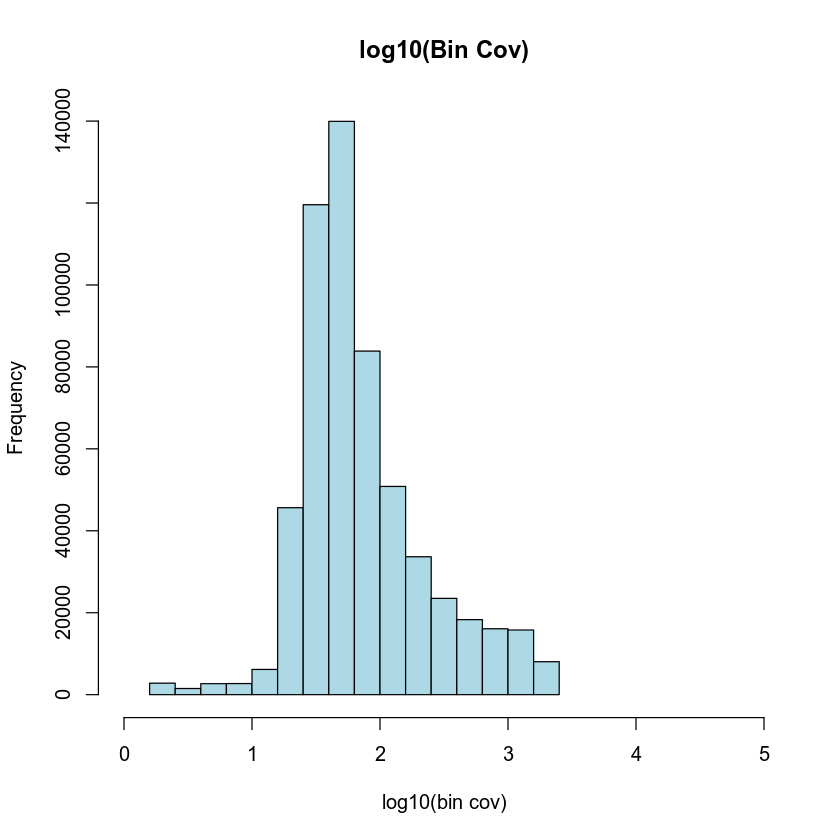

In [19]:
bin.cov = log10(Matrix::colSums(x.sp@bmat)+1);
hist(
  bin.cov[bin.cov > 0], 
  xlab="log10(bin cov)", 
  main="log10(Bin Cov)", 
  col="lightblue", 
  xlim=c(0, 5)
);
bin.cutoff = quantile(bin.cov[bin.cov > 0], 0.95);
idy = which(bin.cov <= bin.cutoff & bin.cov > 0);
x.sp = x.sp[, idy, mat="bmat"];
x.sp

## Dim Reduction

In [20]:
rowCovs = Matrix::rowSums(x.sp@bmat)

### If more than 10,000 cells

In [218]:
row.covs = log10(rowCovs+1);
row.covs.dens = density(
    x = row.covs, 
    bw = 'nrd', adjust = 1
  );
sampling_prob = 1 / (approx(x = row.covs.dens$x, y = row.covs.dens$y, xout = row.covs)$y + .Machine$double.eps); 

In [219]:
set.seed(1);
idx.landmark.ds = sort(sample(x = seq(nrow(x.sp)), size = 10000, prob = sampling_prob));
x.landmark.sp = x.sp[idx.landmark.ds,];
x.query.sp = x.sp[-idx.landmark.ds,];

In [220]:
table(x.landmark.sp@sample)


  D0  D10  D12  D14   D2   D4   D6   D8 
1333  827  809 2033 1401 1114 1303 1180 

In [221]:
x.landmark.sp = runDiffusionMaps(
    obj= x.landmark.sp,
    input.mat="bmat", 
    num.eigs=50
);

Epoch: checking the inputs ...
Epoch: computing jaccard similarity matrix ...
Epoch: fitting regression model ...
Epoch: performing normalization ...
Epoch: computing eigen decomposition ...
Epoch: Done


In [ ]:
x.query.sp = runDiffusionMapsExtension(
    obj1=x.landmark.sp, 
    obj2=x.query.sp,
    input.mat="bmat"
  );

Epoch: checking the inputs ...
Epoch: computing jaccard similarity matrix ...


In [ ]:
x.landmark.sp@metaData$landmark = 1;
x.query.sp@metaData$landmark = 0;
x.sp = snapRbind(x.landmark.sp, x.query.sp);
## combine landmarks and query cells;
x.sp = x.sp[order(x.sp@sample),]; # IMPORTANT
rm(x.landmark.sp, x.query.sp); # free memory

# IMP: recompute since order has changed
# rowCovs = Matrix::rowSums(x.sp@bmat)

In [40]:
rowCovs = Matrix::rowSums(x.sp@bmat)

### If <10000 cells

In [21]:
# if not landmark + query
x.sp = runDiffusionMaps(
    obj= x.sp,
    input.mat="bmat", 
    num.eigs=50
);

rowCovs = Matrix::rowSums(x.sp@bmat)

Epoch: checking the inputs ...

Epoch: computing jaccard similarity matrix ...

Epoch: fitting regression model ...

Epoch: performing normalization ...

Epoch: computing eigen decomposition ...

Epoch: Done



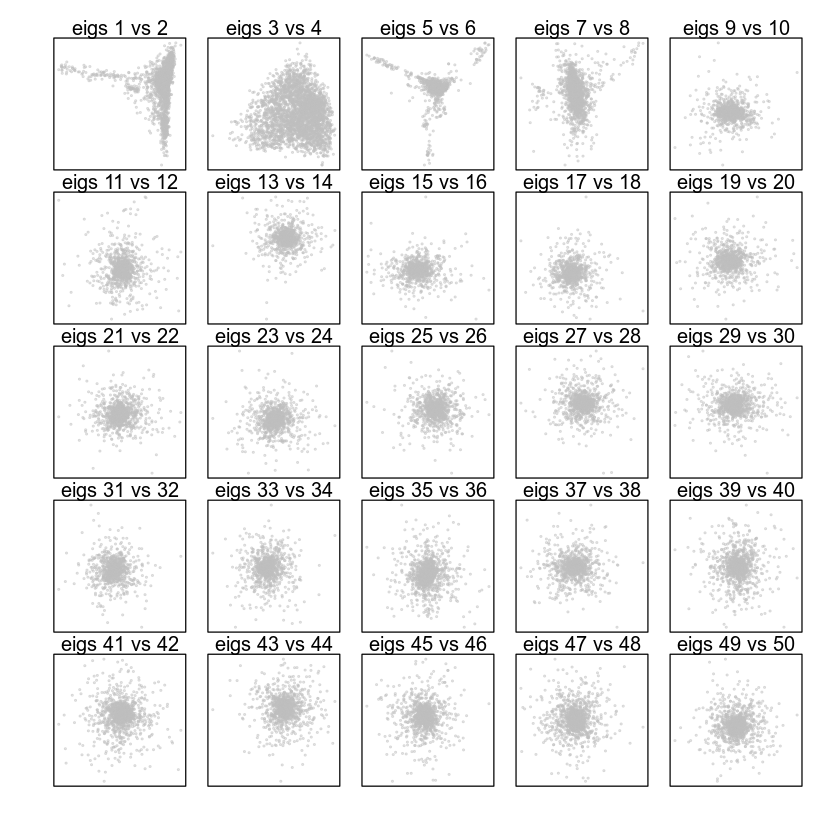

In [22]:
plotDimReductPW(
    obj=x.sp, 
    eigs.dims=1:50,
    point.size=0.3,
    point.color="grey",
    point.shape=19,
    point.alpha=0.6,
    down.sample=5000,
    pdf.file.name=NULL, 
    pdf.height=7, 
    pdf.width=7
  );

In [32]:
x.sp = runKNN(
    obj= x.sp,
    eigs.dim=1:16,
    k=15
  );

In [33]:
library(leiden)

In [34]:
x.sp = runCluster(
   obj=x.sp,
   tmp.folder=tempdir(),
   louvain.lib="leiden",
#    path.to.snaptools=NULL,
   seed.use=10
);
x.sp@metaData$cluster = x.sp@cluster;

In [35]:
table(x.sp@cluster)


  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15 
632 362 319 317 287 256 251 241 162 103  71  70  39  35  20 

In [23]:
x.sp = runViz(
    obj=x.sp, 
    tmp.folder=tempdir(),
    dims=2,
    eigs.dims=1:16, 
    method="umap",
    seed.use=10,
    num.cores=10,
  );

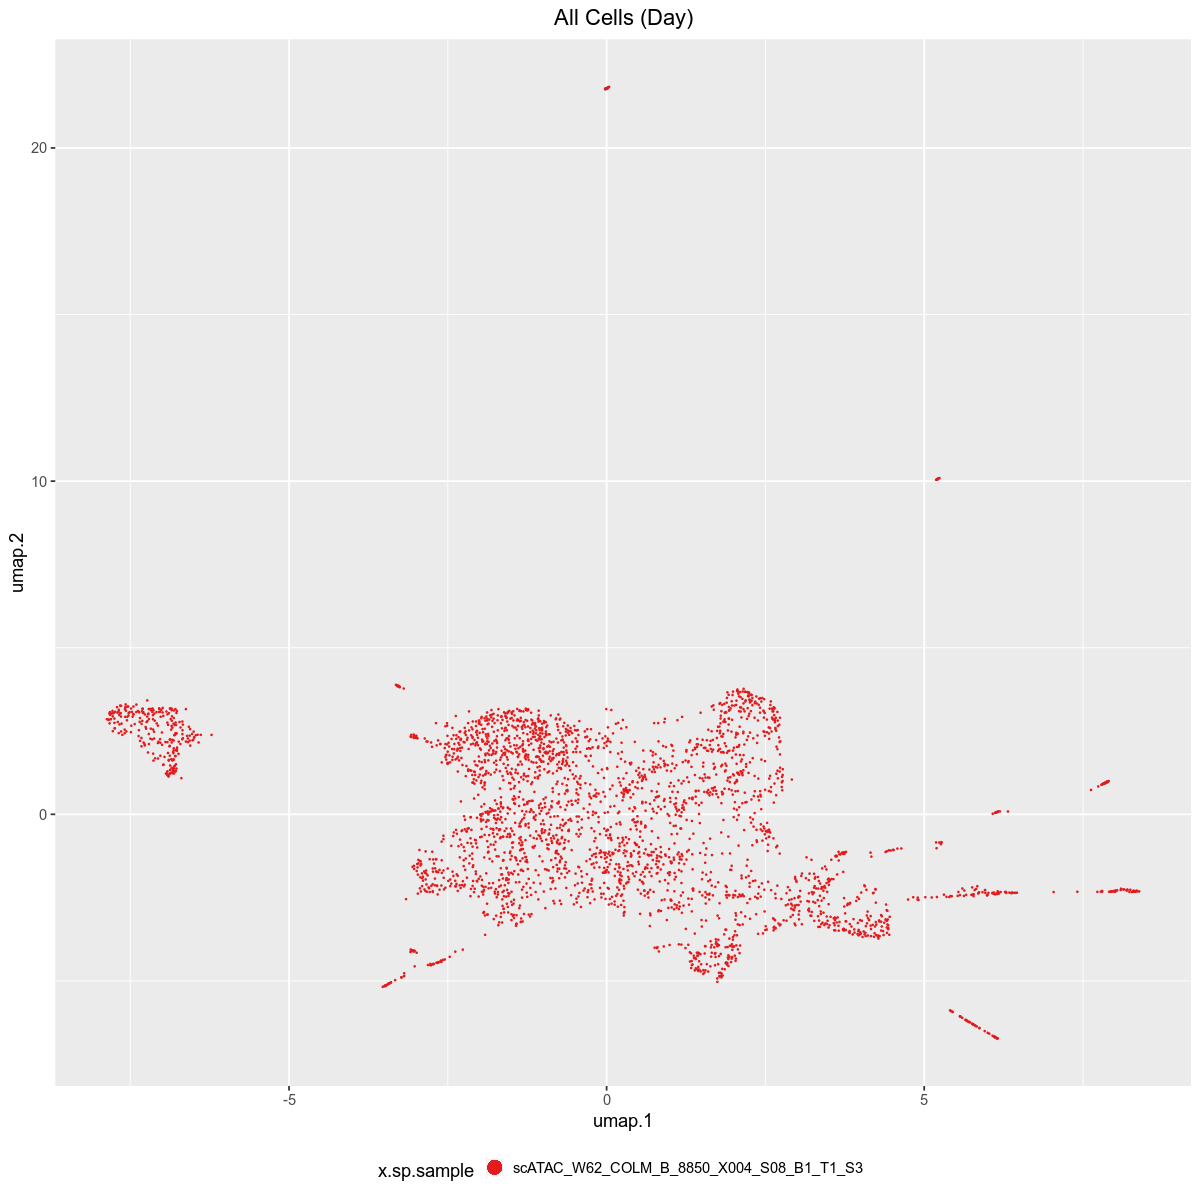

In [24]:
options(repr.plot.width = 10, repr.plot.height = 10)

df = data.frame(x.sp@umap, x.sp@sample)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
geom_point(size=0.1, alpha=1, aes(x=umap.1 , y=umap.2, col=x.sp.sample)) +
scale_color_brewer(breaks=SAMPLES, palette = "Set1") +
ggtitle("All Cells (Day)") + 
theme(plot.title = element_text(hjust = 0.5)) + 
theme(legend.position="bottom", legend.key.size=unit(1,"point")) +
guides(colour = guide_legend(override.aes = list(shape=16, alpha=1, size=4), nrow=4))
# ggsave(sprintf("./figs/%s_5kb_selectedBarcodes_gt1000_wD28_n%d_UMAP_day.pdf", 
#                format(Sys.Date(), "%Y%m%d"), dim(x.sp@bmat)[1]))

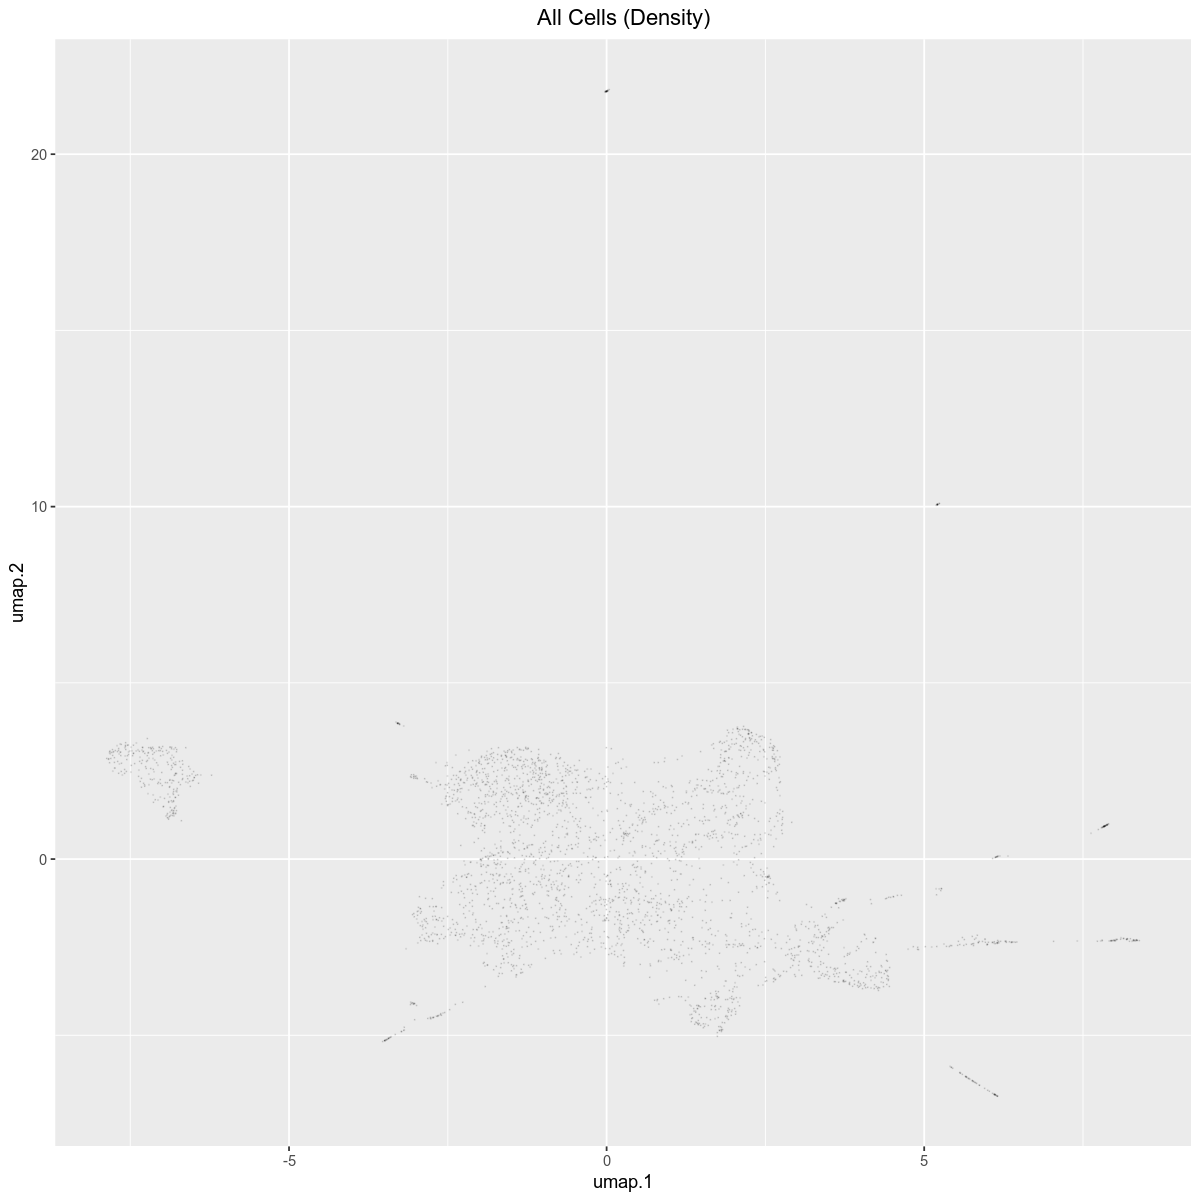

In [25]:
df = data.frame(x.sp@umap, x.sp@sample)

ggplot(df) +
geom_point(shape=20, size=0.05, alpha=0.1, aes(x=umap.1 , y=umap.2)) +
ggtitle("All Cells (Density)") + 
theme(plot.title = element_text(hjust = 0.5)) 

In [26]:
library(RColorBrewer)
qual_col_pals = brewer.pal.info[brewer.pal.info$category == 'qual',]
col_vector = unlist(mapply(brewer.pal, qual_col_pals$maxcolors, rownames(qual_col_pals)))

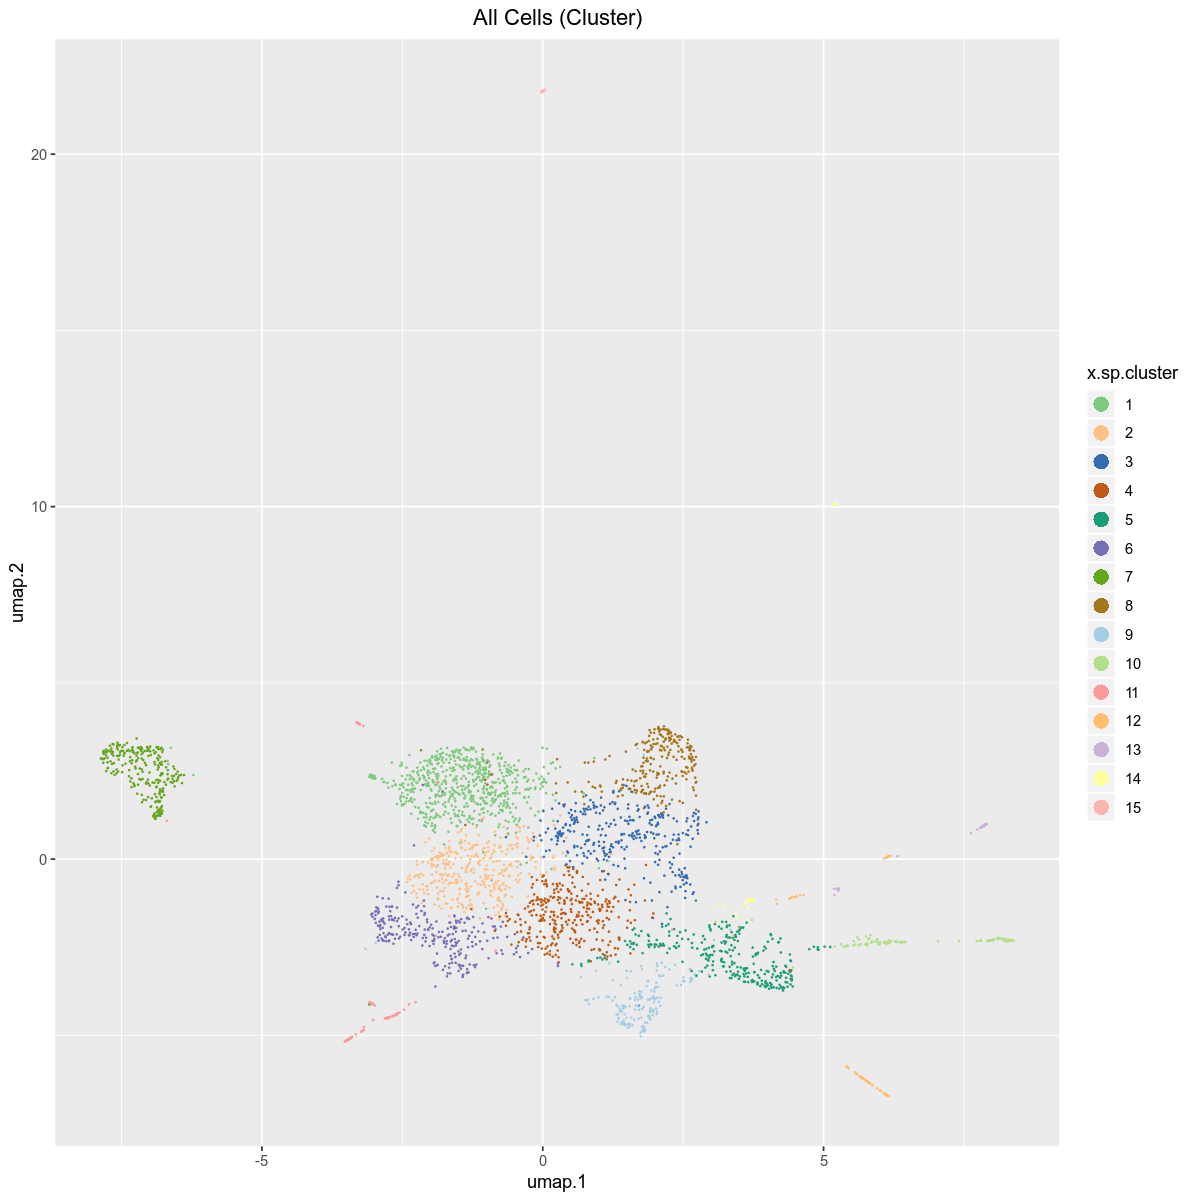

In [36]:
df = data.frame(x.sp@umap, x.sp@cluster)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df, aes(x=umap.1, y=umap.2, col=x.sp.cluster)) +
geom_point(size=0.1, alpha=1) +
scale_colour_manual(values = col_vector[seq(1,74, 2)]) +
ggtitle("All Cells (Cluster)") + 
theme(plot.title = element_text(hjust = 0.5)) + 
guides(colour = guide_legend(override.aes = list(shape=16, alpha=1, size=4))) 

In [28]:
table(x.sp@sample[x.sp@cluster=="12"])

< table of extent 0 >

In [ ]:
library(TxDb.Hsapiens.UCSC.hg38.knownGene)
txdb = TxDb.Hsapiens.UCSC.hg38.knownGene
prom.hg38 = promoters(genes(txdb), upstream = 2000, downstream = 0)
overlaps = findOverlaps(x.sp@feature, prom.hg38);
idy = queryHits(overlaps)
promoter_ratio = Matrix::rowSums(x.sp@bmat[,idy]) / Matrix::rowSums(x.sp@bmat);

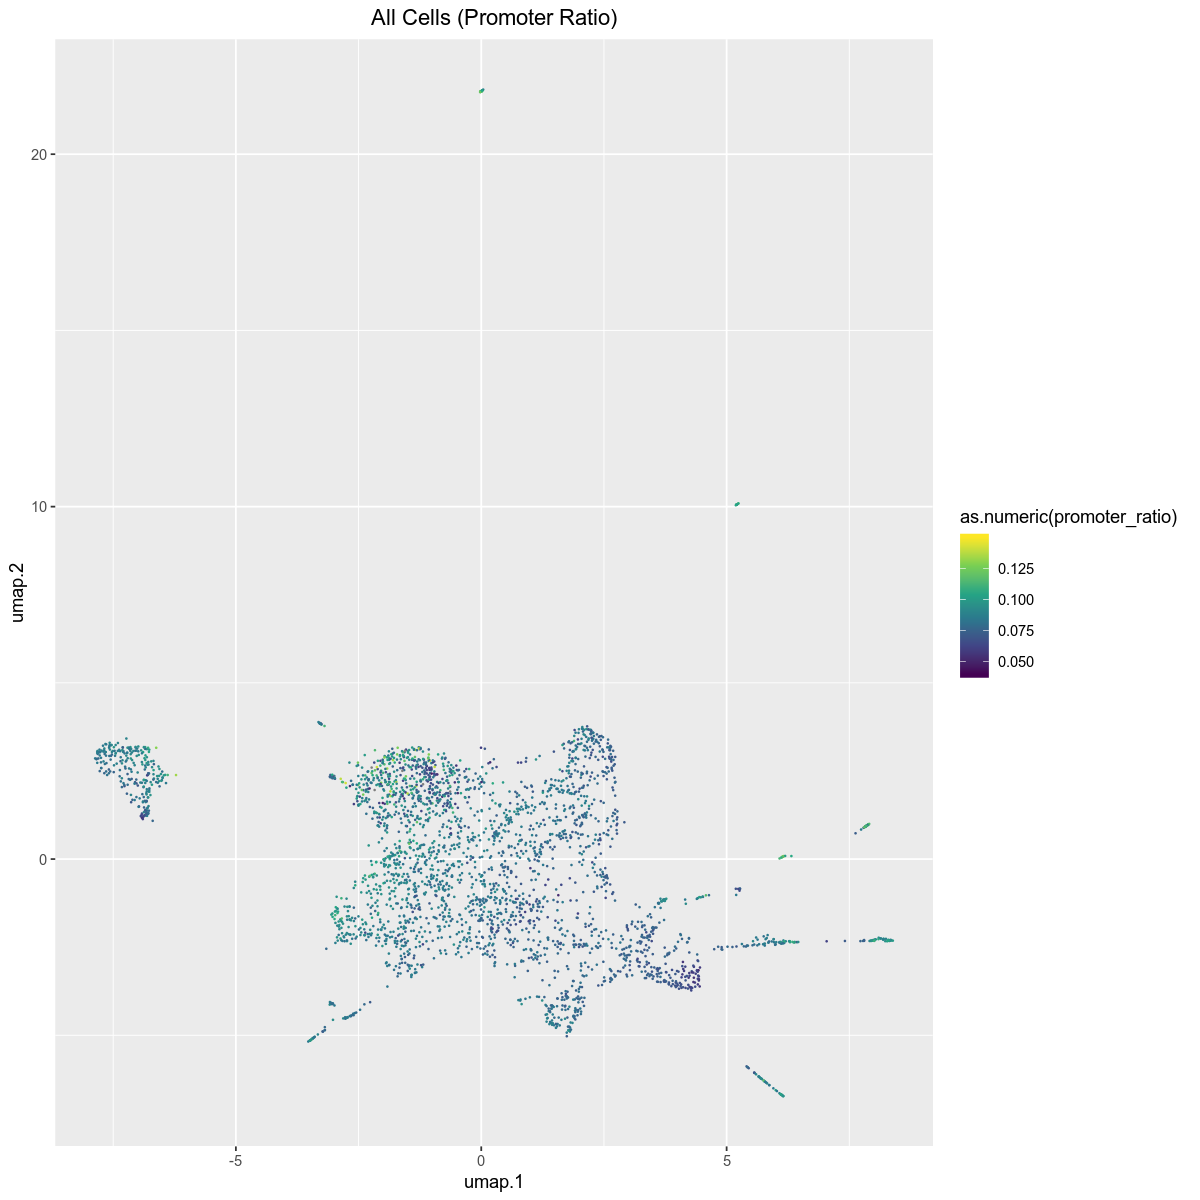

In [30]:
df = data.frame(x.sp@umap, promoter_ratio)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df, aes(x=umap.1, y=umap.2, col=as.numeric(promoter_ratio))) +
geom_point(size=0.1, alpha=1) +
scale_color_viridis_c(lim=c(0.04,0.15)) +
ggtitle("All Cells (Promoter Ratio)") + 
theme(plot.title = element_text(hjust = 0.5)) 

#     pdf.file.name = sprintf("./figs/%s_5kb_selectedBarcodes_gt1000_n%d_UMAP_day", format(Sys.Date(), "%Y%m%d"), dim(x.sp@bmat)[1])

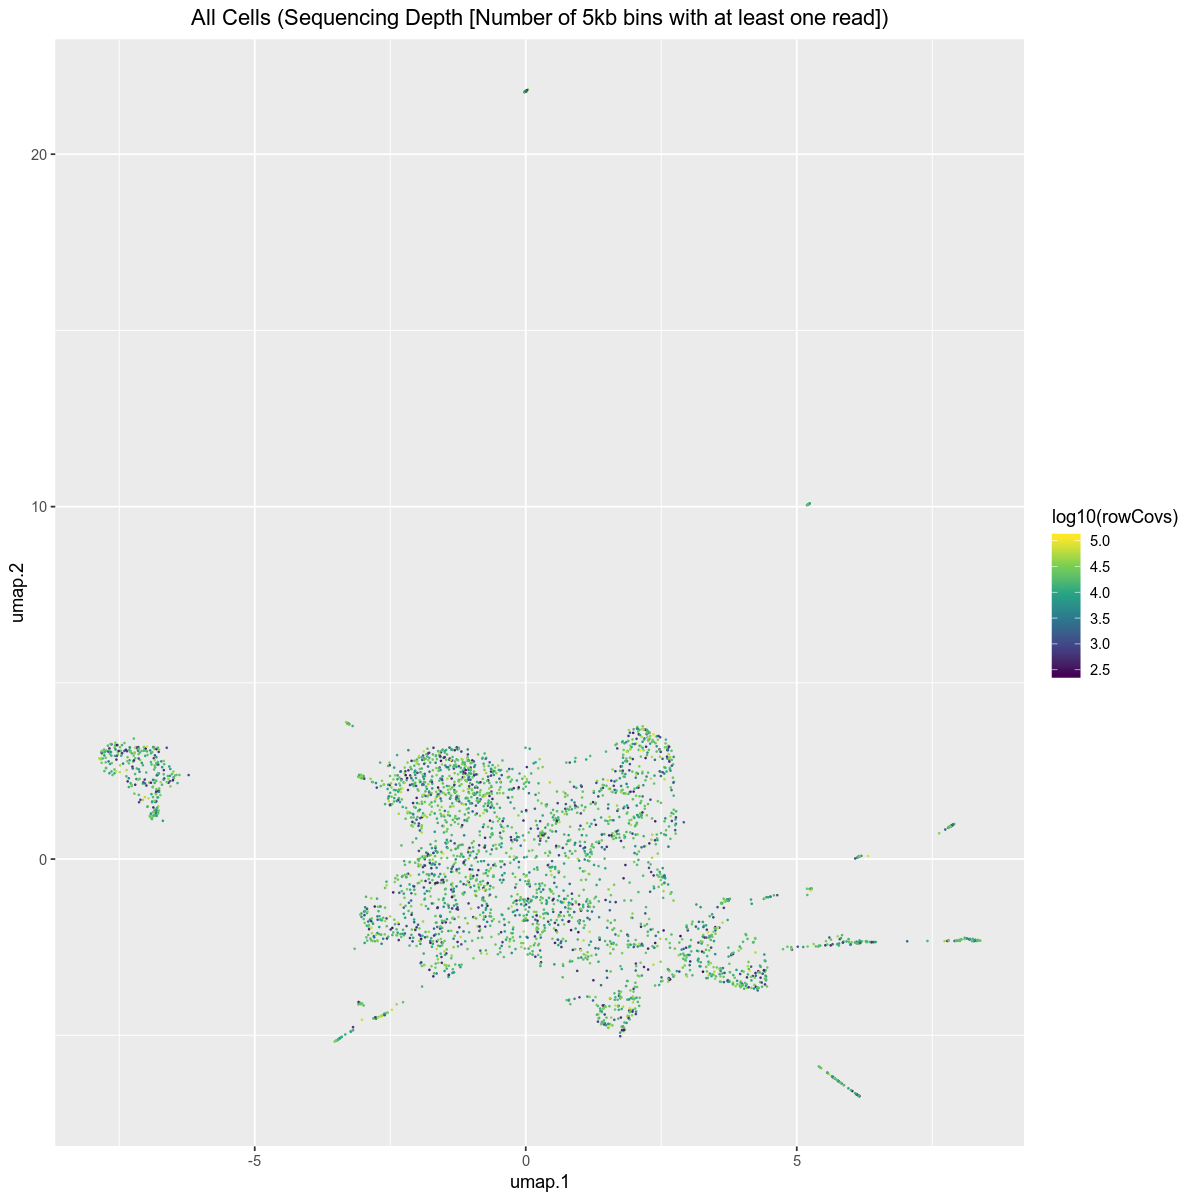

In [41]:
###### df = data.frame(x.sp@umap, rowCovs)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df, aes(x=umap.1, y=umap.2, col=log10(rowCovs))) +
geom_point(size=0.1, alpha=1) +
scale_color_viridis_c() +
ggtitle("All Cells (Sequencing Depth [Number of 5kb bins with at least one read])") + 
theme(plot.title = element_text(hjust = 0.5)) 

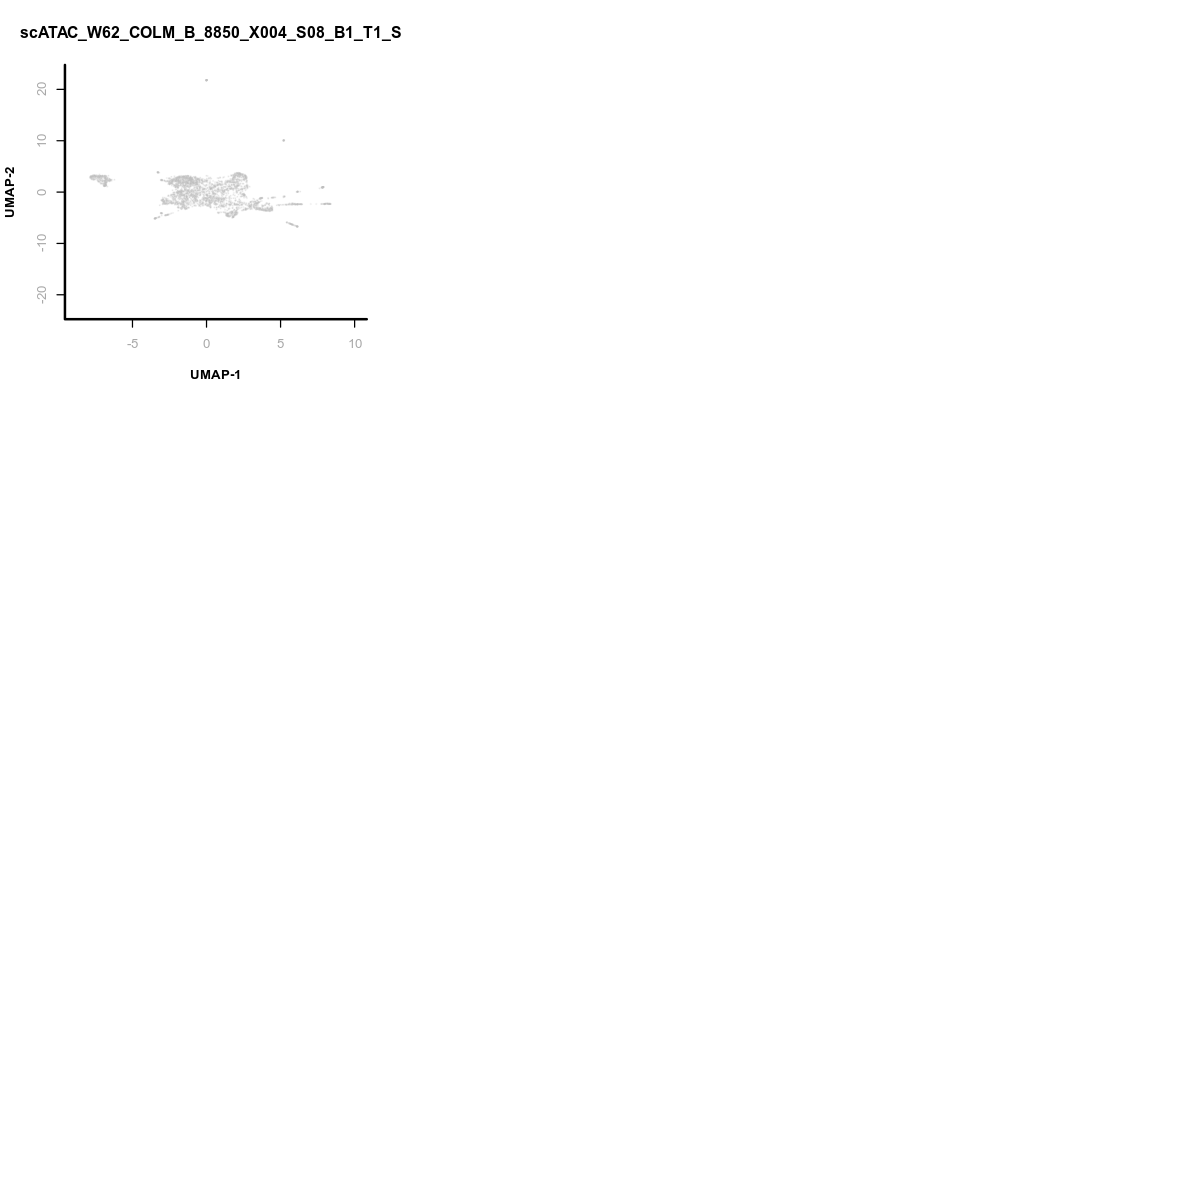

In [37]:
par(mfrow = c(3, 3));
for(d in SAMPLES){
  plotViz(
    obj=x.sp,
    method="umap", 
    main=d,
    point.color=x.sp@sample==d, 
    point.size=0.01,
    point.alpha=0.2,
    text.add= FALSE,
    down.sample=10000,
    legend.add=FALSE,
#     pdf.file.name = sprintf("./figs/%s_5kb_selectedBarcodes_gt1000_n%d_UMAP_day", format(Sys.Date(), "%Y%m%d"), dim(x.sp@bmat)[1])
  );
}

In [72]:
library(harmony)

In [74]:
x.after.sp = runHarmony(
    obj=x.sp, 
    eigs.dim=1:16, 
    meta_data=x.sp@sample # sample index
  );

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony 4/10

Harmony 5/10

Harmony 6/10

Harmony 7/10

Harmony converged after 7 iterations



In [77]:
x.after.sp = runViz(
  obj=x.after.sp, 
  tmp.folder=tempdir(),
  dims=2,
  eigs.dims=1:16, 
  method="umap",
  seed.use=10
);

Warning message:
“Removed 17 rows containing missing values (geom_point).”


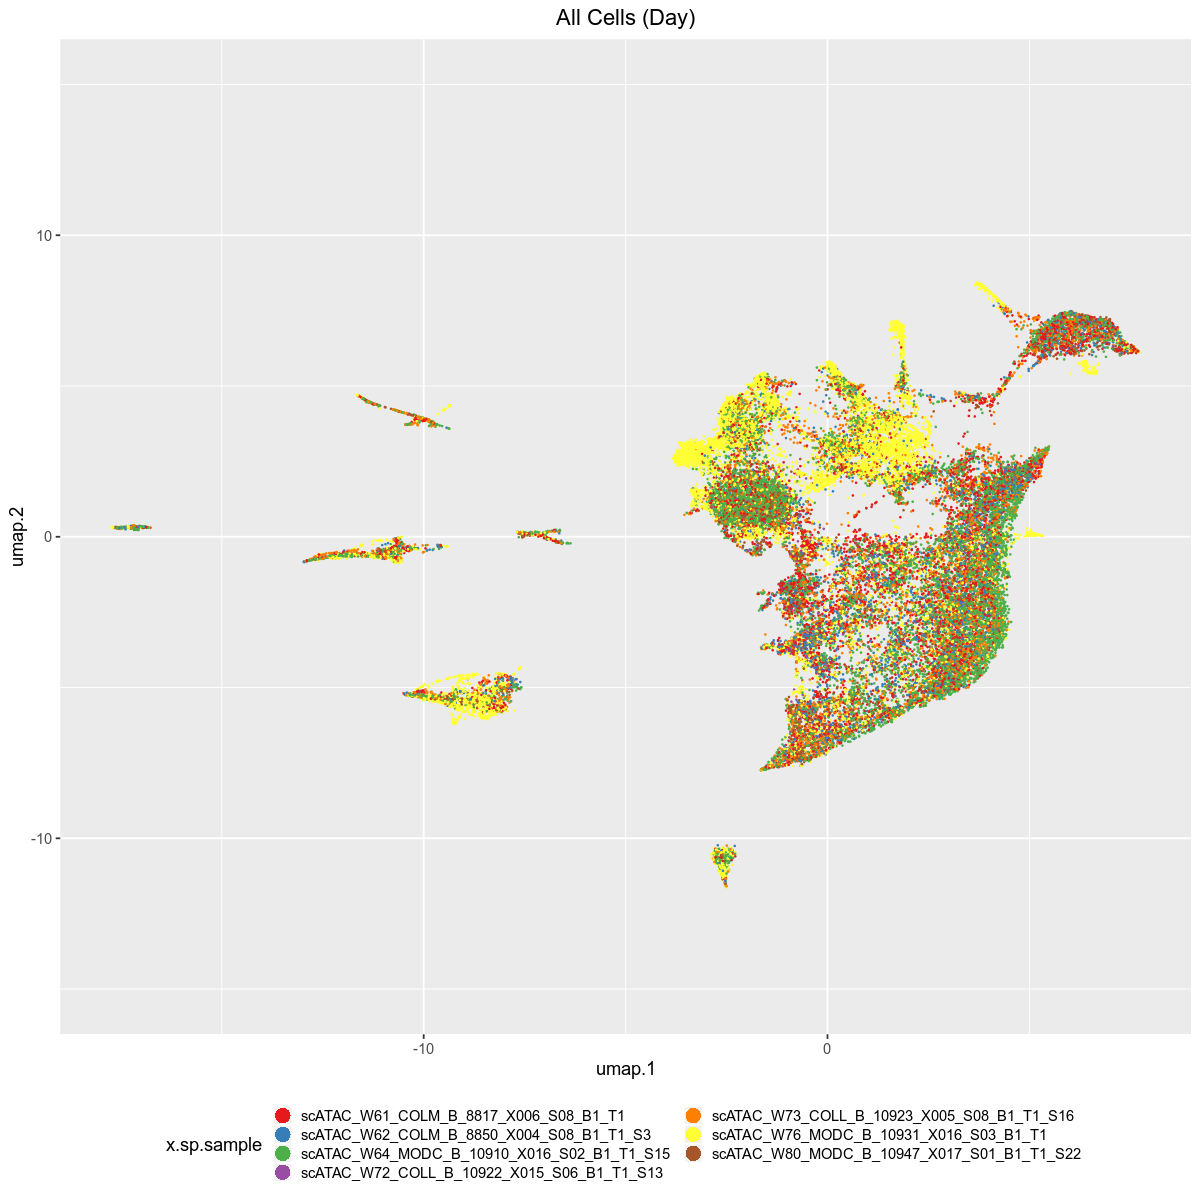

In [84]:
options(repr.plot.width = 10, repr.plot.height = 10)

df = data.frame(x.after.sp@umap, x.sp@sample)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
geom_point(size=0.1, alpha=1, aes(x=umap.1 , y=umap.2, col=x.sp.sample)) +
ylim(-15,15) +
scale_color_brewer(breaks=SAMPLES, palette = "Set1") +
ggtitle("All Cells (Day)") + 
theme(plot.title = element_text(hjust = 0.5)) + 
theme(legend.position="bottom", legend.key.size=unit(1,"point")) +
guides(colour = guide_legend(override.aes = list(shape=16, alpha=1, size=4), nrow=4))
# ggsave(sprintf("./figs/%s_5kb_selectedBarcodes_gt1000_wD28_n%d_UMAP_day.pdf", 
#                format(Sys.Date(), "%Y%m%d"), dim(x.sp@bmat)[1]))

In [ ]:
x.after.sp = runKNN(
  obj= x.after.sp,
  eigs.dim=1:16,
  k=15
);
x.after.sp = runCluster(
   obj=x.after.sp,
   tmp.folder=tempdir(),
   louvain.lib="leiden",
   path.to.snaptools=NULL,
   seed.use=10
);
x.after.sp@metaData$cluster = x.after.sp@cluster;

## Write Fragment for each cluster

In [86]:
writeClusterFragmentsToBed <- function(
    obj, 
    output.prefix,
    path.to.snaptools,
    buffer.size=500,
    num.cores=10
){
    fileList = as.list(unique(obj@file));
 
    # check if files are all snap files
    if(any(do.call(c, lapply(fileList, function(x){isSnapFile(x)})) == FALSE)){
        idx = which(do.call(c, lapply(fileList, function(x){isSnapFile(x)})) == FALSE)
        print("error: these files are not snap file")
        print(fileList[idx])
        stop()
    }
    
    # check if FM session exist
    if(any(do.call(c, lapply(fileList, function(x){ "FM" %in% h5ls(x, recursive=1)$name  })) == FALSE)){
        idx = which(do.call(c, lapply(fileList, function(x){ "FM" %in% h5ls(x, recursive=1)$name  })) == FALSE)
        print("error: the following nsap files do not contain FM session")
        print(fileList[idx])
        stop()
    }
        
    # write the following barcodes down
    barcode.files = lapply(fileList, function(file){
        tempfile(tmpdir = tempdir(), fileext = ".barcode.txt");
    })

    bed.files = lapply(fileList, function(file){
        tempfile(tmpdir = tempdir(), fileext = ".bed.gz");
    })
    
    # write down the barcodes
    cat("Epoch: extracting fragments from each snap files ...\n", file = stderr())
    flag.list = lapply(seq(fileList), function(i){
        file.name = fileList[[i]];
        idx = which(obj@file == file.name);
        barcode.use = obj@barcode[idx]
        message(barcode.files[[i]])
        message(bed.files[[i]])
        message(fileList[[i]])
        write.table(barcode.use, file = barcode.files[[i]], append = FALSE, quote = FALSE, sep = "\t",
                         eol = "\n", na = "NA", dec = ".", row.names = FALSE,
                         col.names = FALSE, qmethod = c("escape", "double"),
                         fileEncoding = "")
        
    })

    # extract the fragments belong to the barcodes    
    flag.list = mclapply(seq(fileList), function(i){
        flag = system2(command=path.to.snaptools, 
            args=c("dump-fragment", 
                   "--snap-file", fileList[[i]], 
                   "--output-file", bed.files[[i]], 
                   "--barcode-file", barcode.files[[i]],
                   "--buffer-size", buffer.size
                   )        
            )                
    }, mc.cores=num.cores);
    
    # combine these bed files
    combined.bed = paste(output.prefix, ".bed.gz");
    flag = system2(command="cat", 
        args=c(paste(bed.files, collapse = ' '),
               ">", combined.bed
               )        
        )                
}

In [87]:
cluster_names = names(table(x.sp@cluster))
mclapply(seq(cluster_names), function(i){
    print(cluster_names[i]);
    writeClusterFragmentsToBed(
        obj=x.sp[which(x.sp@cluster==cluster_names[i]),], 
        output.prefix=paste0("/srv/scratch/surag/colorectal/snapATAC_sessions/20200125_n76770/cluster_beds/idx", cluster_names[i]),
        path.to.snaptools="/users/surag/anaconda3/envs/snapATAC/bin/snaptools",
        buffer.size=500, 
        num.cores=1
   );
 }, mc.cores=20);

## Export Meta Data for Session

In [263]:
myExportMetaData <- function(obj, file, slot.names) {
    metaData.ls = lapply(as.list(slot.names), function(x){
        if(x == "barcode"){
            y = data.frame(slot(obj, x));
            colnames(y) = "barcode"
        }else if(x == "tsne"){
            y = data.frame(slot(obj, x));
            colnames(y) = c("tsne1", "tsne2");
        }else if(x == "umap"){
            y = data.frame(slot(obj, x));
            colnames(y) = c("umap1", "umap2");
        }else if(x == "cluster"){
            y = data.frame(slot(obj, x));
            colnames(y) = "cluster"
        }else if(x == "sample"){
            y = data.frame(slot(obj, x));
            colnames(y) = "sample"
        }else{
            y = data.frame(slot(obj, x));
        }
        y
    })
    
    if(!all(sapply(lapply(metaData.ls, nrow), FUN = identical, nrow(metaData.ls[[1]])))){
        stop("slot in subset.names have different length")
    }
    
    metaData.df = do.call(cbind, metaData.ls);

    write.table(metaData.df, file = file, append = FALSE, quote = FALSE, sep = "\t",
                eol = "\n", na = "NA", dec = ".", row.names = FALSE,
                col.names = TRUE, qmethod = c("escape", "double"),
                fileEncoding = "")
}

myExportMetaData(x.sp, "./snapATAC_sessions/20200125_n76770/metadata.tsv", slot.names=c('barcode', 'cluster', 'umap', 'metaData', 'sample'))

In [53]:
write.table(x.sp@smat@dmat, "./snapATAC_sessions/20200125_n76770/eig_mat.tsv", sep="\t", row.names= FALSE, col.names = FALSE, quote = FALSE)

In [74]:
# writing ranges for 5kb and sparse matrix
write.table(data.frame(seqnames=seqnames(x.sp@feature),
                       starts=start(x.sp@feature)-1,
                       ends=end(x.sp@feature)),
            file="./snapATAC_sessions/20200125_n76770/5kb.ranges.bed",
            quote=F, sep="\t", row.names=F, col.names=F)

In [16]:
writeMM(x.sp@bmat, file="./snapATAC_sessions/20200125_n76770/5kb.sparse.mm")

NULL

In [ ]:
# How to get the order in which a list A can be transformed to a list B 
# When both have same unique elements in them
# o(A)   o(B) o(o(B))   o(A)[o(o(B))] <---- that's what you need to do
# 3   ->  4     3           2
# 4   ->  2     2           4 
# 2   ->  1     4           1
# 1   ->  3     1           3

In [32]:
# metaData = read.table("./snapATAC_sessions/20200125_n76770/metadata.tsv", header = T)
# metaData$sample_barcode = paste(as.character(metaData$sample), as.character(metaData$barcode), sep='_')

In [ ]:
# actual_sample_barcode = paste(x.sp.raw@sample, x.sp.raw@barcode, sep="_")

In [ ]:
# sort_order = order(actual_sample_barcode)[order(order(metaData$sample_barcode))]

In [ ]:
# all(actual_sample_barcode[sort_order] == metaData$sample_barcode)

In [42]:
# writeMM(x.sp.raw@bmat[sort_order, ], file="./snapATAC_sessions/20200125_n76770/5kb.full.mm")

NULL